In [74]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset

import numpy as np

from transformers import pipeline, AutoTokenizer, AutoModel

import re

import linecache

from tqdm import tqdm

import matplotlib.pyplot as plt

In [28]:
device = torch.device("cpu")

In [29]:
def clean_up(file_path):
    final_data = []
    lengths = []

    remove_chars = ["<e1>", "</e1>", "<e2>", "</e2>"]

    with open(file_path) as f:
        while True:
            line = f.readline()
            if not line:
                break

            line = line.strip()

            for char in remove_chars:
                line = line.replace(char, "")
            
            # string clean up
            line = re.sub(r'[^a-zA-Z1-9\s]', '', line)
            line = re.sub(' +', ' ', line)
            line = line.lower()

            line_data = line.split("\t")

            final_data += [line_data]

            # sentence lengths
            lengths += [len(line_data[4].split(" "))]
    
    return final_data, lengths


data, lengths = clean_up('data/en_corpora_test.txt')

print(data[10])

['892738', 'breezin', 'album', 'hastype', 'breezin is the fifteenth studio album by jazzsoul guitarist george benson', 'en']


(array([  10.,  224.,  998., 1234., 1284.,  836.,  486.,  250.,  109.,
          31.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

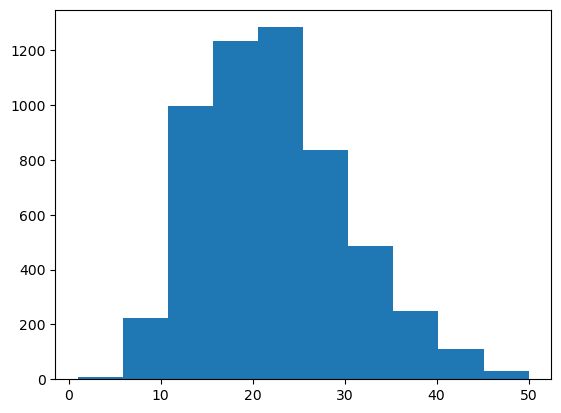

In [30]:
# sequence length frequencies
plt.hist(lengths)

In [45]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

feature_extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

In [46]:
test = feature_extractor("hello how are you")

print(np.array(test).shape)

(1, 4, 768)


In [121]:
class SimpleGRU(nn.Module):
    def __init__(self, feature_extractor, hidden_size, num_layers=4):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = feature_extractor
        
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)

        self.pool = nn.AdaptiveMaxPool1d(1)

        self.sigmoid = nn.Sigmoid()


    def forward(self, input_string, hidden):
        embedded = torch.tensor(self.embedding(input_string))

        final_output = torch.zeros_like(embedded)
        
        for i in range(embedded.shape[1]):
            output, hidden = self.gru(embedded[:,i,:].view(1, 1, -1), hidden)
            final_output[:,i,:] = output
        
        final_output = self.pool(final_output)
        final_output = self.sigmoid(final_output)

        return final_output.squeeze(2)


    def init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [122]:
# embeddings
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

feature_extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer)


model = SimpleGRU(feature_extractor, 768)
start_hidden = model.init_hidden()
output = model("hello how are you", start_hidden)

print(output.shape)

torch.Size([1, 4])


In [123]:
class EntityDataset(Dataset):
    # overriden methods
    def __init__(self, file_path):
        self.file_path = file_path


    def __len__(self):
        with open(self.file_path, "rbU") as f:
            num_lines = sum(1 for _ in f)
        
        # don't count first line
        return num_lines - 1


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = (idx + 1).tolist()
        else:
            idx += 1
        
        particular_line = linecache.getline(self.file_path, idx+1)
        cleaned_sample = self.clean_up(particular_line)

        input_sentence = cleaned_sample[4]
        entity1 = cleaned_sample[1]
        entity2 = cleaned_sample[2]

        sentence_arr = tokenizer(input_sentence)["input_ids"]
        entity1_arr = tokenizer(entity1)["input_ids"]
        entity2_arr = tokenizer(entity2)["input_ids"]

        labels = torch.zeros((len(sentence_arr)))

        for word in sentence_arr:
            for entity in entity1_arr:
                if entity == word:
                    labels[sentence_arr.index(word)] = 1
            for entity in entity2_arr:
                if entity == word:
                    labels[sentence_arr.index(word)] = 1

        return input_sentence, labels
    

    # helper
    def clean_up(self, line):
        remove_chars = ["<e1>", "</e1>", "<e2>", "</e2>"]

        line = line.strip()

        for char in remove_chars:
            line = line.replace(char, "")
        
        # string clean up
        line = re.sub(r'[^a-zA-Z1-9\s]', '', line)
        line = re.sub(' +', ' ', line)
        line = line.lower()

        line_data = line.split("\t")
        
        return line_data

In [124]:
batch_size = 1

dataset = EntityDataset('data/en_corpora_test.txt')

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_9722/1356011285.py:10: DeprecationWarning: 'U' mode is deprecated
  with open(self.file_path, "rbU") as f:


In [125]:
sample = next(iter(train_loader))

print(sample)

[('songs of christmas is the twentysixth album by irish folk music group the irish rovers',), tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
         0., 0., 0., 0., 0.]])]


/tmp/ipykernel_9722/1356011285.py:10: DeprecationWarning: 'U' mode is deprecated
  with open(self.file_path, "rbU") as f:


In [126]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [127]:
EPOCHS = 10

for epoch in range(EPOCHS):
    for _, sample in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        input = sample[0]
        labels = sample[1]

        start_hidden = model.init_hidden()
        output = model(input[0], start_hidden)

        loss = criterion(output, labels)

        loss.backward()

        optimizer.step()

        if _ % 50 == 0:
            print(loss.item())

/tmp/ipykernel_9722/1356011285.py:10: DeprecationWarning: 'U' mode is deprecated
  with open(self.file_path, "rbU") as f:
  0%|          | 1/5461 [00:00<1:09:34,  1.31it/s]

0.8364523649215698


  1%|          | 51/5461 [00:29<57:24,  1.57it/s]  

0.7323015928268433


  2%|▏         | 101/5461 [01:02<53:21,  1.67it/s] 

0.7921422123908997


  3%|▎         | 151/5461 [01:33<1:03:51,  1.39it/s]

0.7423803210258484


  4%|▎         | 201/5461 [02:05<58:48,  1.49it/s]  

0.7458275556564331


  5%|▍         | 251/5461 [02:38<58:59,  1.47it/s]  

0.7506291270256042


  6%|▌         | 301/5461 [03:08<51:32,  1.67it/s]  

0.7459189295768738


  6%|▋         | 351/5461 [03:40<40:37,  2.10it/s]  

0.7190189957618713


  7%|▋         | 401/5461 [04:12<57:01,  1.48it/s]  

0.7162379026412964


  8%|▊         | 451/5461 [04:41<47:51,  1.75it/s]  

0.6341124773025513


  9%|▉         | 501/5461 [05:10<51:20,  1.61it/s]  

0.5753515362739563


 10%|█         | 551/5461 [05:39<43:26,  1.88it/s]

0.5719085335731506


 11%|█         | 601/5461 [06:08<42:26,  1.91it/s]  

0.6369690895080566


 12%|█▏        | 651/5461 [06:39<48:08,  1.67it/s]  

0.5962441563606262


 13%|█▎        | 701/5461 [07:05<47:28,  1.67it/s]

0.6119452118873596


 14%|█▍        | 751/5461 [07:34<41:44,  1.88it/s]  

0.49559181928634644


 15%|█▍        | 801/5461 [08:08<1:10:51,  1.10it/s]

0.5164920687675476


 16%|█▌        | 850/5461 [08:39<47:00,  1.64it/s]  


KeyboardInterrupt: 